In [7]:
from numba import njit
import numpy as np
import math
from numba import prange
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

from numba import njit, prange
from skimage.measure import find_contours
from scipy.stats import binned_statistic
from scipy.ndimage import gaussian_filter1d

In [15]:
folder = '/Users/saramahdavi/Documents/pAct/mutual repression'

delE=4.5
Ka=1.4*10**(-4)
Ki=5.3*10**(-7)
K_c=Ka/Ki

@njit
def pAct(c, K_c=K_c, delE=delE):
    """ probability of repressor/activator being active

    Parameters:
        - c: inducer concentration
        - K_c: dissociation constant in active state / dissociation constant in inactive state
        - delE: energy difference between inactive and active state
    """

    p = (1 + c/Ka)**2 / ((1 + c/Ka)**2 + np.exp(-delE)*(1 + c/Ki)**2)
    #p= (1 + c)**2 / ((1 + c)**2 + np.exp(-delE)*(1 + c*K_c)**2)
    return p

c_values = np.logspace(-7, -4, 100)
pmin=1/(1+K_c**2*np.exp(-delE))
pmax=1/(1+np.exp(-delE))
p_values = np.linspace(pmin, pmax, 1000)

K = 1
r = 2
omegaA = 7.5
omegaB = 7.5

binary_colors = ['blue', 'yellow']
binary_cmap = ListedColormap(binary_colors)

K_values = np.linspace(0.01, 2, 10)

r_values = np.linspace(0.1, 10, 10)
omegaA_values = np.logspace(-3,3, 10)
omegaB_values = np.logspace(-3,3, 10)

n_sampling_c = 100

In [17]:
# we find the roots with a bisection method, to b able to parallelize it with numba
@njit
def find_intersections(x, y1, y2):
    intersections = []
    for i in prange(len(x) - 1):
        diff1 = y1[i] - y2[i]
        diff2 = y1[i + 1] - y2[i + 1]
        if diff1 * diff2 < 0:  # sign change : intersection
            # linear interpolation
            x_intersect = x[i] - diff1 * (x[i + 1] - x[i]) / (diff2 - diff1)
            # linear interpolation
            y_intersect = y1[i] + (y1[i + 1] - y1[i]) * (x_intersect - x[i]) / (x[i + 1] - x[i])
            intersections.append((x_intersect, y_intersect))
    return intersections


@njit
def steady_state(r, K, omegaA, omegaB, pactA, pactB):
  Btilde=np.linspace(0,r,n_sampling_c)
  fA=r/(1+2*pactB*Btilde+omegaB*(pactB*Btilde)**2)
  fm1B=(np.sqrt(1-omegaA*(1-r/Btilde))-1)/omegaA/(pactA/K)
  return find_intersections(Btilde, fA, fm1B)


In [19]:



@njit
def bistable_or_not(r, K, omegaA, omegaB, p_val=p_values):
  npval=len(p_val)
  bs_bool = np.zeros((npval, npval), dtype=np.int64)
  for iA in prange(npval):
    pA=p_val[iA]
    for iB in prange(npval):
      pB=p_val[iB]
      Ass = steady_state(r, K, omegaA, omegaB, pA, pB)
      if len(Ass) == 1:
        bs_bool[iA, iB] = 0
      else:
        bs_bool[iA, iB] = 1
  return bs_bool


@njit
def bistab_exploration_omegaA_omegaB(r, K, omegaA_values, omegaB_values, p_val=p_values):
  nsampling=len(omegaA_values)
  bistable_omegaA_omegaB = np.zeros((nsampling,nsampling))
  for iA in prange(nsampling):
    omegaAval=omegaA_values[iA]
    for iB in prange(nsampling):
      omegaBval=omegaB_values[iB]
      heatmap=bistable_or_not(r, K, omegaAval, omegaBval, p_val)
      bool_bistable = np.any(heatmap == 1)
      bistable_omegaA_omegaB[iA,iB] = int(bool_bistable)
  return bistable_omegaA_omegaB


@njit
def omega_min_bistab_for_K(r, K_values, omega_values, p_val=p_values):
  n_K = len(K_values)
  n_omega = len(omega_values)
  omega_bistab_for_K  = np.zeros(n_K)
  omega_list = np.full((n_K,n_omega),np.nan)
  for ik in prange(n_K):
    Kval=K_values[ik]
    for i_omega in prange(n_omega):
      omegaval=omega_values[i_omega]
      heatmap=bistable_or_not(r, Kval, omegaval, omegaval, p_val)
      bool_bistable = np.any(heatmap == 1)
      if bool_bistable:
        omega_list[ik][i_omega] = omegaval
    omega_bistab = np.nanmin(omega_list[ik])
    omega_bistab_for_K[ik] = omega_bistab
  return omega_bistab_for_K

@njit
def omegaA_min_bistab_for_K_and_omegaB(r, K_values, omega_values, p_val=p_values):
  n_K = len(K_values)
  n_omega = len(omega_values)
  omega_bistab_for_K_and_omegaB  = np.zeros((n_K,n_omega))
  for ik in prange(n_K):
    Kval=K_values[ik]
    for i_omega in prange(n_omega):
      omegaBval=omega_values[i_omega]
      omega_list = np.full(n_omega,np.nan)
      for j_omega in prange(n_omega):
        omegaAval=omega_values[j_omega]
        heatmap=bistable_or_not(r, Kval, omegaAval, omegaBval, p_val)
        bool_bistable = np.any(heatmap == 1)
        if bool_bistable:
          omega_list[j_omega] = omegaAval
      omegaA_min_bistab = np.nanmin(omega_list)
      omega_bistab_for_K_and_omegaB[ik][i_omega] = omegaA_min_bistab
  return omega_bistab_for_K_and_omegaB



@njit
def K_max_min_bistab_for_K_and_omegaB(r, K_values, omega_values, p_val=p_values):
  n_K = len(K_values)
  n_omega = len(omega_values)
  K_min_for_omegaA_and_omegaB = np.zeros((n_omega,n_omega))
  K_max_for_omegaA_and_omegaB = np.zeros((n_omega,n_omega))
  for i_omegaA in prange(n_omega):
    omegaAval=omega_values[i_omegaA]
    for i_omegaB in prange(n_omega):
      omegaBval=omega_values[i_omegaB]
      K_list = np.full(n_K,np.nan)
      for ik in prange(n_K):
        Kval = K_values[ik]
        heatmap=bistable_or_not(r, Kval, omegaAval, omegaBval, p_val)
        bool_bistable = np.any(heatmap == 1)
        if bool_bistable:
          K_list[ik] = Kval
      K_max = np.nanmax(K_list)
      K_min = np.nanmin(K_list)
      K_min_for_omegaA_and_omegaB[i_omegaA][i_omegaB] = K_min
      K_max_for_omegaA_and_omegaB[i_omegaA][i_omegaB] = K_max
  return K_min_for_omegaA_and_omegaB, K_max_for_omegaA_and_omegaB


In [21]:
## to save the bistability phase space in (w1,w2) space - they take a long time to run
def storing_array_csv(L, omegaA_values, omegaB_values, p_values, r, K):
    filename = folder + 'bistable_map_logomegamax='+str(int(np.log10(min(omegaA_values))))+'_logomegamax='+str(int(np.log10(max(omegaA_values))))+'_nsampling='+str(len(omegaA_values))+'_np='+str(len(p_values))+'_r='+str(r)+'_K='+str(K)+'.csv'
    OmegaA, OmegaB = np.meshgrid(omegaA_values, omegaB_values)

    data = {
        "omegaA": OmegaA.ravel(),
        "omegaB": OmegaB.ravel(),
        "L_value": L.ravel()
    }

    df = pd.DataFrame(data)
    df.to_csv(filename, index=False)

    print(f"Saved {len(df)} rows to '{filename}'")

In [19]:
nsampling=200
p_values = np.linspace(pmin, pmax,200 )
omegaA_values = np.logspace(0,2,nsampling)
omegaB_values = np.logspace(0,2,nsampling)

In [21]:
nsampling=200
p_values = np.linspace(pmin, pmax,200 )
omegaA_values = np.logspace(0,2,nsampling)
omegaB_values = np.logspace(0,2,nsampling)
L=bistab_exploration_omegaA_omegaB(r, K, omegaA_values, omegaB_values, p_val=p_values)

In [23]:
np.shape(L)
OmegaA, OmegaB = np.meshgrid(omegaA_values, omegaB_values)
np.shape(OmegaA)

(200, 200)

In [177]:
storing_array_csv(L, omegaA_values, omegaB_values, p_values,2,1)

Saved 10000 rows to '/Users/saramahdavi/Documents/pAct/mutual repressionbistable_map_logomegamax=0_logomegamax=2_nsampling=100_np=100_r=2_K=1.csv'


In [321]:
nsampling=100
p_values = np.linspace(pmin, pmax,100 )
omegaA_values = np.logspace(-1,5,nsampling)
omegaB_values = np.logspace(-1,5,nsampling)
L_r=[]
K=1
r_list = [0.7,0.8,0.9]
for r_val in r_list:
    L=bistab_exploration_omegaA_omegaB(r_val, K, omegaA_values, omegaB_values, p_val=p_values)
    L_r+=[L]

0.8571428571428572
0.5
0.22222222222222232


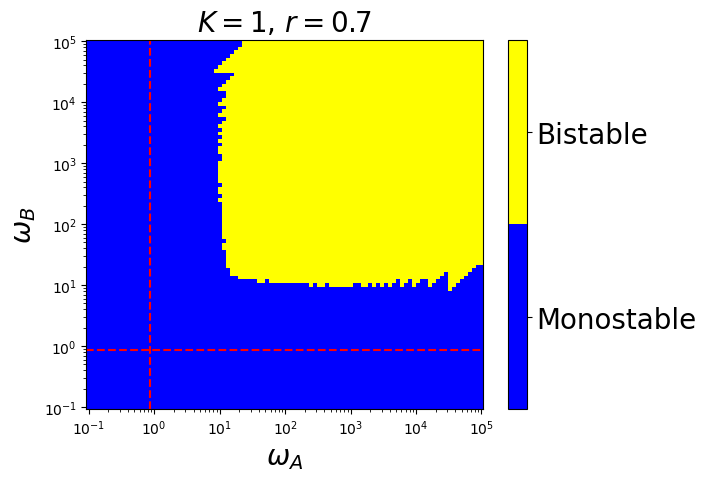

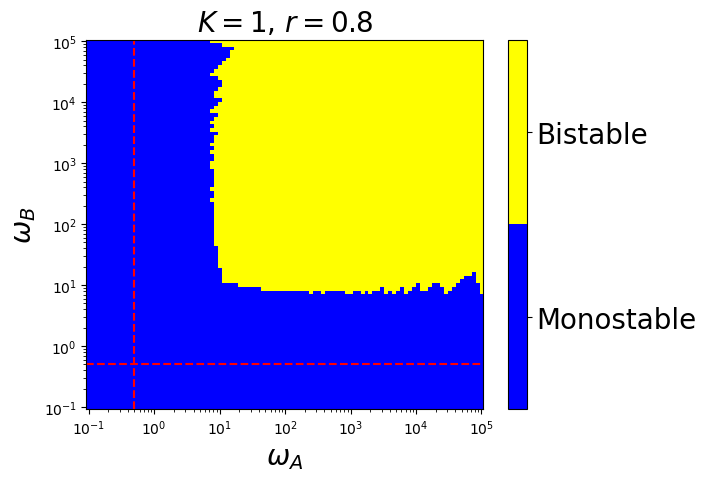

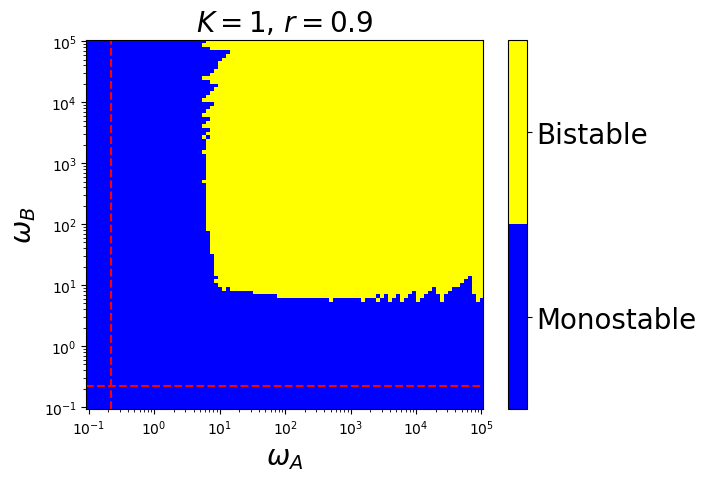

In [322]:
for i in range(len(r_list)):
    plt.figure()
    plt.pcolormesh((omegaA_values), (omegaA_values), np.transpose(L_r[i]), cmap=binary_cmap, shading='auto',vmin=0,vmax=1)
    print(2*(1/r_list[i]-1))
    plt.axvline(x=2*(1/r_list[i]-1), color='r', linestyle='--')
    plt.axhline(y=2*(1/r_list[i]-1), color='r', linestyle='--')
    plt.xscale('log')
    plt.yscale('log')
    # plt.xticks([1, 4, 10, 100], [r"$10^0$", "4", r"$10^1$", r"$10^2$"],size =17)
    # plt.yticks([1, 4, 10, 100], [r"$10^0$", "4", r"$10^1$", r"$10^2$"],size =17)
    plt.xlabel(r'$\omega_A$',size =20)
    plt.ylabel(r'$\omega_B$',size =20)
    plt.title('$K=$'+str(K)+', $r=$'+str(r_list[i]),size =20)
    cbar = plt.colorbar()
    cbar.set_ticks([0.25, 0.75])
    cbar.set_ticklabels(['Monostable', 'Bistable'],size=20)

In [279]:
nsampling=100
p_values = np.linspace(pmin, pmax,100 )
omegaA_values = np.logspace(0,5,nsampling)
omegaB_values = np.logspace(0,5,nsampling)
L_r=[]
K=1
r_list = [0.05,0.1,0.5]
for r_val in r_list:
    L=bistab_exploration_omegaA_omegaB(r_val, K, omegaA_values, omegaB_values, p_val=p_values)
    L_r+=[L]

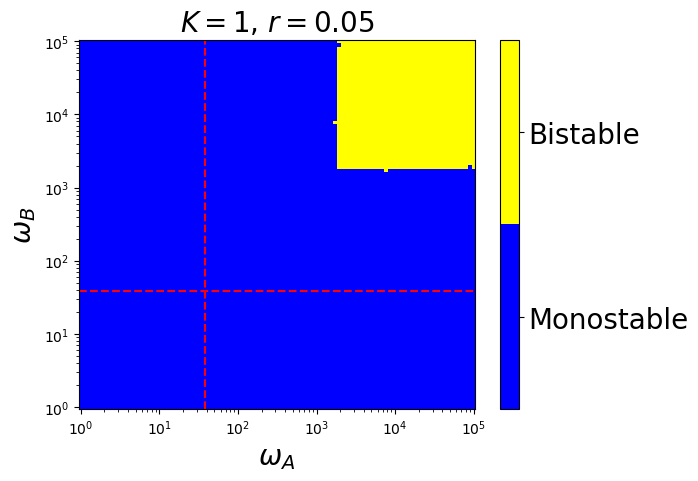

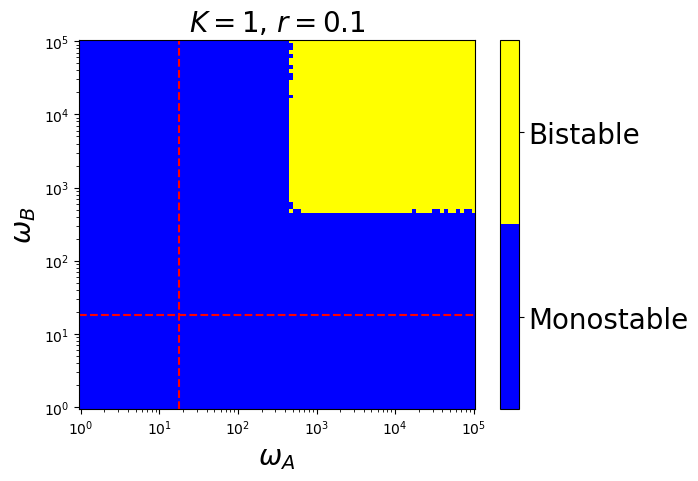

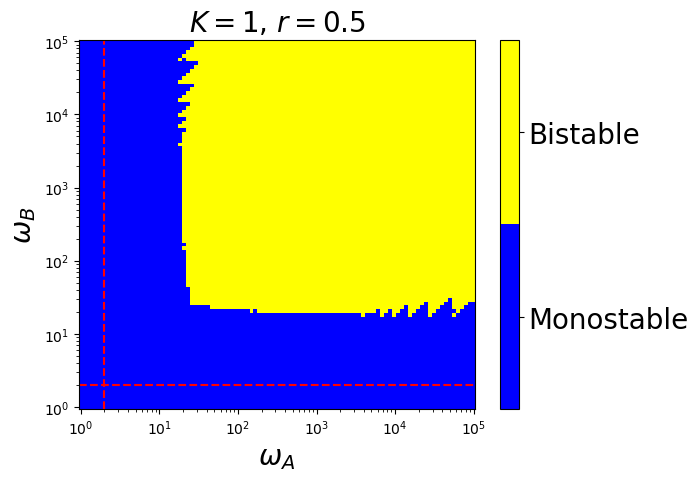

In [280]:
for i in range(len(r_list)):
    plt.figure()
    plt.pcolormesh((omegaA_values), (omegaA_values), np.transpose(L_r[i]), cmap=binary_cmap, shading='auto',vmin=0,vmax=1)
    plt.axvline(x=2*(1/r_list[i]-1), color='r', linestyle='--')
    plt.axhline(y=2*(1/r_list[i]-1), color='r', linestyle='--')
    plt.xscale('log')
    plt.yscale('log')
    # plt.xticks([1, 4, 10, 100], [r"$10^0$", "4", r"$10^1$", r"$10^2$"],size =17)
    # plt.yticks([1, 4, 10, 100], [r"$10^0$", "4", r"$10^1$", r"$10^2$"],size =17)
    plt.xlabel(r'$\omega_A$',size =20)
    plt.ylabel(r'$\omega_B$',size =20)
    plt.title('$K=$'+str(K)+', $r=$'+str(r_list[i]),size =20)
    cbar = plt.colorbar()
    cbar.set_ticks([0.25, 0.75])
    cbar.set_ticklabels(['Monostable', 'Bistable'],size=20)

In [295]:
import numpy as np
from numba import njit, prange

nsampling = 200
omegaA_values = np.logspace(0, 2, nsampling)
omegaB_values = np.logspace(0, 2, nsampling)
p_values = np.linspace(pmin, pmax, 500)

#r_list = np.array([1, 2, 5, 6, 7, 10, 20])
r_list = np.array([1,2])
K_fixed = 1  

# Parallelized wrapper to compute all L matrices
@njit(parallel=True)
def bistability_map_for_different_r(r_vals, omegaA, omegaB, p_val, K):
    n = len(r_vals)
    L_stack = np.empty((n, len(omegaB), len(omegaA)))
    for i in prange(n):
        L_stack[i] = bistab_exploration_omegaA_omegaB(r_vals[i], K, omegaA_values, omegaB_values, p_val=p_values)
    return L_stack

# Run the parallel computation
L_r_3 = bistability_map_for_different_r(r_list, omegaA_values, omegaB_values, p_values, K_fixed)

In [ ]:
[0.01,0.05,0.1,0.5]

import numpy as np
from numba import njit, prange

nsampling = 300
omegaA_values = np.logspace(-2, 2, nsampling)
omegaB_values = np.logspace(-2, 2, nsampling)
p_values = np.linspace(pmin, pmax, 1000)

r_list = np.array([1, 2, 5, 6, 7, 10, 20])
#r_list = np.array([10, 20])
K_fixed = 1                              

# Parallelized wrapper to compute all L matrices
@njit(parallel=True)
def bistability_map_for_different_r(r_vals, omegaA, omegaB, p_val, K):
    n = len(r_vals)
    L_stack = np.empty((n, len(omegaB), len(omegaA)))
    for i in prange(n):
        L_stack[i] = bistab_exploration_omegaA_omegaB(r_vals[i], K, omegaA_values, omegaB_values, p_val=p_values)
    return L_stack

# Run the parallel computation
L_r_all = bistability_map_for_different_r(r_list, omegaA_values, omegaB_values, p_values, K_fixed)

In [ ]:
import numpy as np
from numba import njit, prange

nsampling = 300
omegaA_values = np.logspace(-2, 2, nsampling)
omegaB_values = np.logspace(-2, 2, nsampling)
p_values = np.linspace(pmin, pmax, 1000)

r_list = np.array([1, 2, 5, 6, 7, 10, 20])
#r_list = np.array([10, 20])
K_fixed = 1                              

# Parallelized wrapper to compute all L matrices
@njit(parallel=True)
def bistability_map_for_different_r(r_vals, omegaA, omegaB, p_val, K):
    n = len(r_vals)
    L_stack = np.empty((n, len(omegaB), len(omegaA)))
    for i in prange(n):
        L_stack[i] = bistab_exploration_omegaA_omegaB(r_vals[i], K, omegaA_values, omegaB_values, p_val=p_values)
    return L_stack

# Run the parallel computation
L_r_all = bistability_map_for_different_r(r_list, omegaA_values, omegaB_values, p_values, K_fixed)

In [ ]:
for i in range(len(r_list)):
    storing_array_csv(L_r_all[i], omegaA_values, omegaB_values, p_values,r_list[i],1)

In [286]:
import numpy as np
from numba import njit, prange

nsampling = 200
omegaA_values = np.logspace(-2, 2, nsampling)
omegaB_values = np.logspace(-2, 2, nsampling)
p_values = np.linspace(pmin, pmax, 500)

#r_list = np.array([1, 2, 5, 6, 7, 10, 20])
r_list = np.array([10, 20])
K_fixed = 1  

# Parallelized wrapper to compute all L matrices
@njit(parallel=True)
def bistability_map_for_different_r(r_vals, omegaA, omegaB, p_val, K):
    n = len(r_vals)
    L_stack = np.empty((n, len(omegaB), len(omegaA)))
    for i in prange(n):
        L_stack[i] = bistab_exploration_omegaA_omegaB(r_vals[i], K, omegaA_values, omegaB_values, p_val=p_values)
    return L_stack

# Run the parallel computation
L_r_2 = bistability_map_for_different_r(r_list, omegaA_values, omegaB_values, p_values, K_fixed)

In [296]:
for i in range(len(r_list)):
    storing_array_csv(L_r_3[i], omegaA_values, omegaB_values, p_values,r_list[i],1)

Saved 40000 rows to '/Users/saramahdavi/Documents/pAct/mutual repressionbistable_map_logomegamax=0_logomegamax=2_nsampling=200_np=500_r=1_K=1.csv'
Saved 40000 rows to '/Users/saramahdavi/Documents/pAct/mutual repressionbistable_map_logomegamax=0_logomegamax=2_nsampling=200_np=500_r=2_K=1.csv'


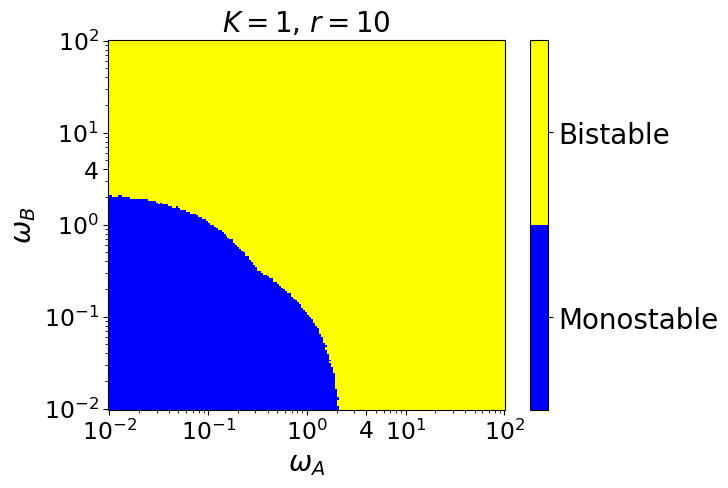

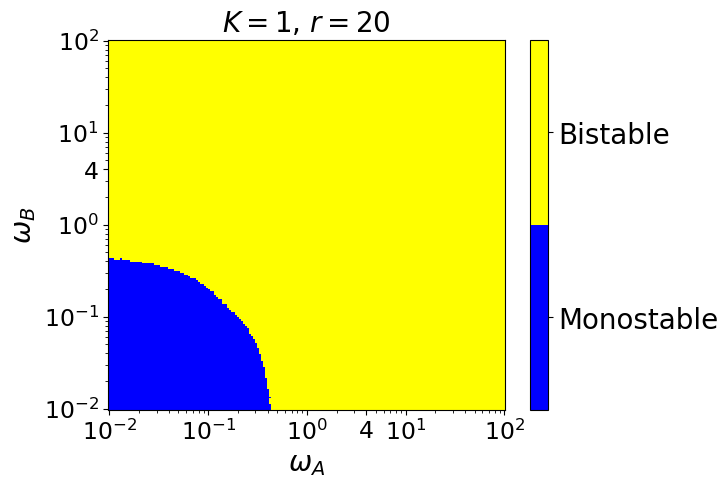

In [290]:

for i in range(len(r_list)):
    plt.figure()
    plt.pcolormesh((omegaA_values), (omegaA_values), np.transpose(L_r_2[i]), cmap=binary_cmap, shading='auto',vmin=0,vmax=1)
    plt.xscale('log')
    plt.yscale('log')
    plt.xticks([0.01,0.1,1, 4, 10, 100], [r"$10^{-2}$", r"$10^{-1}$",r"$10^0$", "4", r"$10^1$", r"$10^2$"],size =17)
    plt.yticks([0.01,0.1,1, 4, 10, 100], [r"$10^{-2}$",r"$10^{-1}$",r"$10^0$", "4", r"$10^1$", r"$10^2$"],size =17)
    plt.xlabel(r'$\omega_A$',size =20)
    plt.ylabel(r'$\omega_B$',size =20)
    plt.title('$K=$'+str(K)+', $r=$'+str(r_list[i]),size =20)
    cbar = plt.colorbar()
    cbar.set_ticks([0.25, 0.75])
    cbar.set_ticklabels(['Monostable', 'Bistable'],size=20)

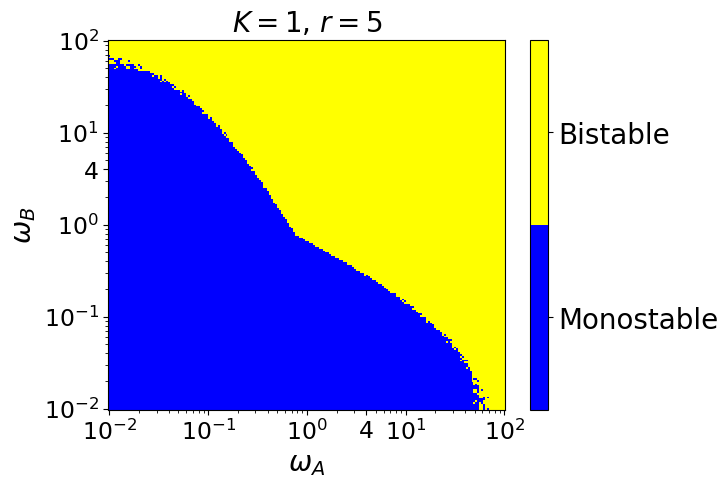

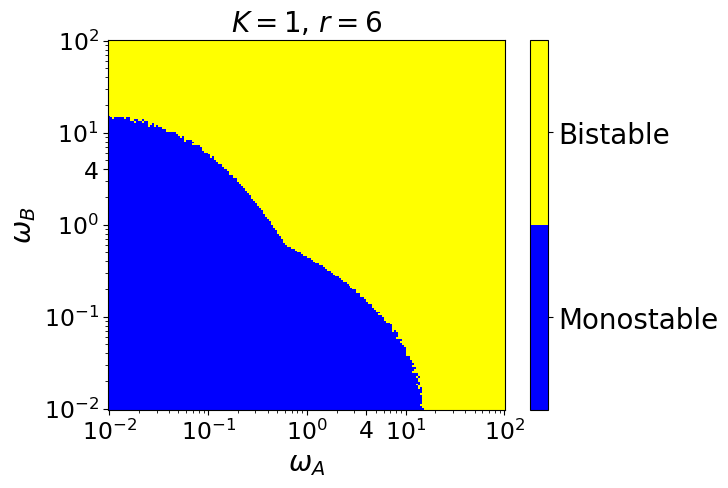

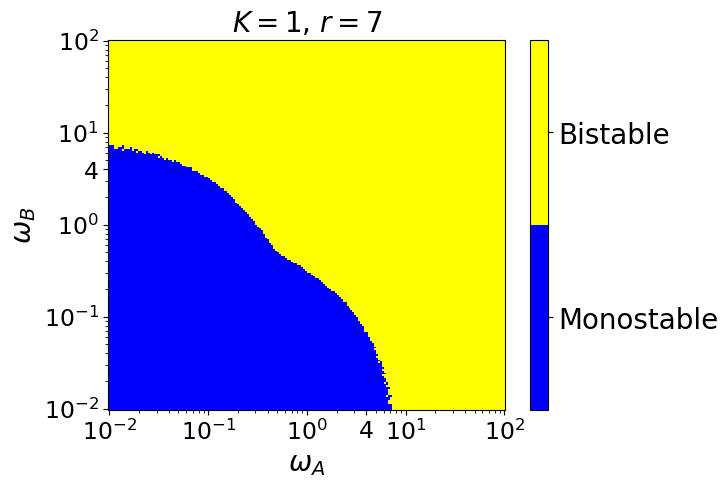

In [270]:
r_list = np.array([2])
for i in range(len(r_list)):
    plt.figure()
    plt.pcolormesh((omegaA_values), (omegaA_values), np.transpose(L_r[i]), cmap=binary_cmap, shading='auto',vmin=0,vmax=1)
    plt.xscale('log')
    plt.yscale('log')
    plt.xticks([0.01,0.1,1, 4, 10, 100], [r"$10^{-2}$", r"$10^{-1}$",r"$10^0$", "4", r"$10^1$", r"$10^2$"],size =17)
    plt.yticks([0.01,0.1,1, 4, 10, 100], [r"$10^{-2}$",r"$10^{-1}$",r"$10^0$", "4", r"$10^1$", r"$10^2$"],size =17)
    plt.xlabel(r'$\omega_A$',size =20)
    plt.ylabel(r'$\omega_B$',size =20)
    plt.title('$K=$'+str(K)+', $r=$'+str(r_list[i]),size =20)
    cbar = plt.colorbar()
    cbar.set_ticks([0.25, 0.75])
    cbar.set_ticklabels(['Monostable', 'Bistable'],size=20)

In [325]:
import pandas as pd
import numpy as np

def load_array_from_csv(filename):
    """
    Load a CSV file with columns: omegaA, omegaB, L_value
    and reconstruct the 2D array L, omegaA_values, and omegaB_values.

    Returns:
        L (2D array): Reconstructed array of shape (len(omegaB), len(omegaA))
        omegaA_values (1D array)
        omegaB_values (1D array)
    """
    df = pd.read_csv(filename)

    # Extract and sort unique omega values
    omegaA_values = np.sort(df['omegaA'].unique())
    omegaB_values = np.sort(df['omegaB'].unique())

    # Create mapping from value to index
    omegaA_idx = {v: i for i, v in enumerate(omegaA_values)}
    omegaB_idx = {v: i for i, v in enumerate(omegaB_values)}

    # Initialize array
    L = np.empty((len(omegaB_values), len(omegaA_values)))

    # Fill the array using the index maps
    for _, row in df.iterrows():
        i = omegaB_idx[row['omegaB']]
        j = omegaA_idx[row['omegaA']]
        L[i, j] = row['L_value']

    return L, omegaA_values, omegaB_values


In [333]:
r_list = [0.9,0.7,0.5,0.1,0.01]
LL =[]
omega_list =[]
for i in range(len(r_list)):
    filename_r = '/Users/saramahdavi/Documents/pAct/mutual repressionbistable_map_logomegamax=-1_logomegamax=5_nsampling=300_np=1000_r='+str(r_list[i])+'_K=1.csv'
    L_of_r, omegaa,omegab = load_array_from_csv(filename_r)
    LL+= [L_of_r]
    omega_list +=[omegaa]

In [345]:
import numpy as np
from numba import njit, prange

nsampling = 100
omegaA_values = np.logspace(-1, 5, nsampling)
omegaB_values = np.logspace(-1, 5, nsampling)
p_values = np.linspace(pmin, pmax,200)

#r_list = np.array([1, 2, 5, 6, 7, 10, 20])
r_list = np.array([0.9])
K_fixed = 1  

# Parallelized wrapper to compute all L matrices
@njit(parallel=True)
def bistability_map_for_different_r(r_vals, omegaA, omegaB, p_val, K):
    n = len(r_vals)
    L_stack = np.empty((n, len(omegaB), len(omegaA)))
    for i in prange(n):
        L_stack[i] = bistab_exploration_omegaA_omegaB(r_vals[i], K, omegaA_values, omegaB_values, p_val=p_values)
    return L_stack

# Run the parallel computation
L_r_2 = bistability_map_for_different_r(r_list, omegaA_values, omegaB_values, p_values, K_fixed)



In [307]:
r_list = [1,2,5,6,7,10,20]
LL =[]
omega_list =[]
for i in range(len(r_list)):
    if i==0 or i==1:
        filename_r = '/Users/saramahdavi/Documents/pAct/mutual repressionbistable_map_logomegamax=0_logomegamax=2_nsampling=200_np=500_r='+str(r_list[i])+'_K=1.csv'
    else: 
        filename_r = '/Users/saramahdavi/Documents/pAct/mutual repressionbistable_map_logomegamax=-2_logomegamax=2_nsampling=200_np=500_r='+str(r_list[i])+'_K=1.csv'
    L_of_r, omegaa,omegab = load_array_from_csv(filename_r)
    LL+= [L_of_r]
    omega_list +=[omegaa]

In [308]:
name='/Users/saramahdavi/Documents/pAct/mutual repressionbistable_map_logomegamax=-2_logomegamax=2_nsampling=300_np=1000_r=2_K=1.csv'

In [159]:
LLris2, omegaa0,omegab0 = load_array_from_csv(name)

In [311]:
def n_hill(omega):
    return -(1/2/omega*(np.sqrt(1+4*omega)-1)-2)

/var/folders/0f/1y6hnbr10kvdck573q6z0g_r0000gn/T/ipykernel_19584/671615848.py:21: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for collection in cs.collections:


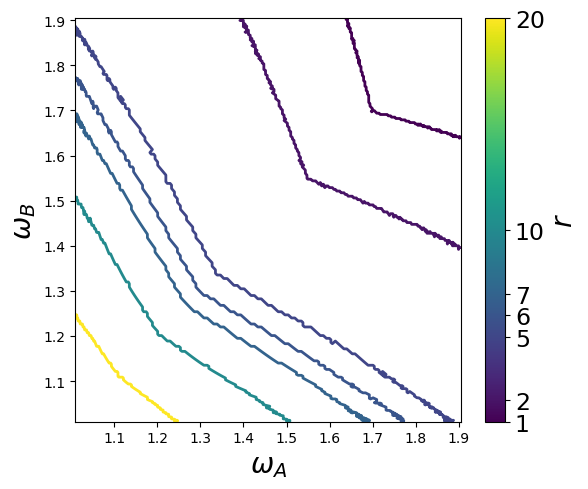

In [313]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm
import matplotlib.colors as colors


#LL=L_r + L_r_2
# Custom colormap normalized to the range of r values
norm = colors.Normalize(vmin=min(r_list), vmax=max(r_list))
cmap = cm.viridis  # Or any other colormap

# Create the figure and axis
fig, ax = plt.subplots(figsize=(6, 5))


# Plot each contour with a unique color from the colormap
for i, r in enumerate(r_list):
    Z = np.transpose(LL[i])
    omegaA_values, omegaB_values = omega_list[i], omega_list[i]
    cs = ax.contour(n_hill(omegaA_values), n_hill(omegaB_values), Z, levels=[0.5],colors=[cmap(norm(r))], linewidths=2, linestyles='solid')
    for collection in cs.collections:
    
        for path in collection.get_paths():
            i+=1
            verts = path.vertices
            x, y = verts[:, 0], verts[:, 1]
   
    #clean_y = gaussian_filter1d(y, sigma=3)
    #plt.plot(x,clean_y,'.')

# Add labels and log scales
# ax.set_xscale('log')
# ax.set_yscale('log')
#ax.set_xticks([0.01,0.1,1, 4, 10, 100])
#ax.set_xticklabels( [r"$10^{-2}$", r"$10^{-1}$",r"$10^0$", "4", r"$10^1$", r"$10^2$"], size=17)
#ax.set_yticks([0.01,0.1,1, 4, 10, 100])
#ax.set_yticklabels( [r"$10^{-2}$", r"$10^{-1}$",r"$10^0$", "4", r"$10^1$", r"$10^2$"], size=17)
ax.set_xlabel(r'$\omega_A$', size=20)
ax.set_ylabel(r'$\omega_B$', size=20)
#ax.set_title(f'$K={K}$ — Contours for different $r$', size=20)
# Add a colorbar for r values
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # dummy for colorbar
cbar = plt.colorbar(sm, ax=ax, ticks=r_list)
cbar.set_label(r'$r$', size=20)
cbar.ax.tick_params(labelsize=17)

plt.tight_layout()
plt.show()
